In [1]:
# %pip install pandas
# %pip install scikit-learn
# %pip install plotly
# %pip install numpy
# %pip install matplotlib
# %pip install nbformat
# %pip install opencv-python
# %pip install tensorflow
# %pip install wandb
# %pip install imblearn
# %pip install seaborn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import os
import plotly.express as px
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

import wandb
%env "WANDB_NOTEBOOK_NAME" "model_data_augmentation_mobilenetv2.ipynb"

wandb.login()

from wandb.integration.keras import WandbMetricsLogger

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


env: "WANDB_NOTEBOOK_NAME"="model_data_augmentation_mobilenetv2.ipynb"


wandb: Currently logged in as: pedro-mariani (dspro2-group9). Use `wandb login --relogin` to force relogin


In [3]:
label_df = pd.read_csv(
    "../../../data/processed/combined/combined_label.csv", index_col=False
)
data_dir = "../../../data/processed/combined/img/"

label_df.head()

,image_name,expression_label
0,angry_0.jpg,angry
1,angry_1.jpg,angry
2,fear_2.jpg,fear
3,angry_4.jpg,angry
4,angry_5.jpg,angry


In [4]:
label_df["expression_label"] =  label_df["expression_label"].astype("category")
label_df.dtypes

image_name            object
expression_label    category
dtype: object

In [5]:
def load_data(dir_path, img_size):
    X = []

    for index, row in label_df.iterrows():
        image_path = os.path.join(dir_path, row["image_name"])
        img = cv2.imread(image_path)
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA).astype("float32")

        X.append(img)

    X = np.array(X)
    dummies = pd.get_dummies(label_df["expression_label"])   

    return X, dummies.values

In [6]:
IMG_SIZE = (96, 96)

X, y = load_data(data_dir, IMG_SIZE)

In [7]:
train_ratio = 0.60
test_ratio = 0.20
validation_ratio = 0.20


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_ratio / (train_ratio + test_ratio), random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(40257, 96, 96, 3)
(13419, 96, 96, 3)
(13420, 96, 96, 3)
(40257, 7)
(13419, 7)
(13420, 7)


# Distribution of classes in each set


In [8]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
class_count_in_train_set = np.sum(y_train, axis=0)

fig = px.bar(x=labels, y=class_count_in_train_set, color=labels)

fig.update_layout(
    title="Distribution of each label in train set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [9]:
class_count_in_validation_set = np.sum(y_valid, axis=0)
fig = px.bar(x=labels, y=class_count_in_validation_set, color=labels)

fig.update_layout(
    title="Distribution of each label in validation set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

In [10]:
class_count_in_test_set = np.sum(y_test, axis=0)
fig = px.bar(x=labels, y=class_count_in_test_set, color=labels)

fig.update_layout(
    title="Distribution of each label in test set",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

# Oversampling with SMOTE


In [11]:
# get all dimensions of the resulting X
n_samples, height, width, n_channels = [X_train.shape[index] for index in range(4)]

# reshape X because SMOTE accepts only (n_samples, n_channels*height*weight)-type data
X_train_reshaped = X_train.reshape(n_samples, n_channels * height * width)

X_train_reshaped.shape

(40257, 27648)

In [12]:
# initialize the SMOTE model
smote = SMOTE(random_state=42)

# perform re-sampling on modified X given y
X_train_smote, y_train_smote = smote.fit_resample(X_train_reshaped, y_train)
X_train_smote = X_train_smote.reshape(len(X_train_smote), height, width, n_channels)

print(X_train_smote.shape)
print(y_train_smote.shape)

(53242, 96, 96, 3)
(53242, 7)


In [13]:
class_count_in_train_smote_set = np.sum(y_train_smote, axis=0)
fig = px.bar(x=labels, y=class_count_in_train_smote_set, color=labels)

fig.update_layout(
    title="Distribution of each label in train set after SMOTE",
    xaxis_title="Expressions",
    yaxis_title="Count",
    height=600,
    width=800,
)

fig.update_traces(texttemplate="%{y}", textposition="inside")

fig.show()

# Model training with data augmentation


In [14]:
base_model = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,)
)

base_model.trainable = False

In [15]:
NUM_CLASSES = 7

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [16]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Emotion Recognition",
    name="mobileNetV2_epoch30_100_batch128",
    # track hyperparameters and run metadata with wandb.config
    config={
        "architecture": "MobileNetV2",
        "optimizer": "adam",
        "optimizer_2": "Adam(learning_rate=1e-5)",
        "loss": "categorical_crossentropy",
        "metric": ["categorical_accuracy"],
        "epochs": 30,
        "epochs_2": 100,
        "batch_size": 128,
        "IMG_SIZE": "96, 96",
        "Dense_1": 512,
        "Dense_1_activation": "relu",
        "Dropout": 0.4,
        "Dense_2": 7,
        "Dense_2_activation": "softmax",
    },
)

config = wandb.config

In [17]:
# augment and normalize/standardize for training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True,
)

# only normalize/standardize for validation and test set
test_val_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
)


# get batch iterator for training
train_iterator = train_datagen.flow(
    X_train_smote, y_train_smote, batch_size=config["batch_size"]
)
# get batch iterator for validation
val_iterator = test_val_datagen.flow(X_valid, y_valid, batch_size=config["batch_size"])

# get batch iterator for test (use only once for evaluation)
test_iterator = test_val_datagen.flow(X_test, y_test, batch_size=config["batch_size"])

In [18]:
model.compile(
    loss=config["loss"],
    optimizer=config["optimizer"], 
    metrics=config["metric"],
)

history = model.fit(
    train_iterator,
    validation_data=val_iterator,
    epochs=config["epochs"],
    callbacks=[WandbMetricsLogger(log_freq=5)],
)

Epoch 1/30


e:\Documents\HSLU\Studium\Workspaces\Python\DSPRO2\emotion_recognition\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

wandb: ERROR Unable to log learning rate.


416/416 ━━━━━━━━━━━━━━━━━━━━ 132s 306ms/step - categorical_accuracy: 0.2087 - loss: 2.6997 - val_categorical_accuracy: 0.2752 - val_loss: 1.8017
Epoch 2/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 128s 306ms/step - categorical_accuracy: 0.2823 - loss: 1.7799 - val_categorical_accuracy: 0.3416 - val_loss: 1.7232
Epoch 3/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 128s 306ms/step - categorical_accuracy: 0.2958 - loss: 1.7494 - val_categorical_accuracy: 0.3497 - val_loss: 1.7091
Epoch 4/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 134s 320ms/step - categorical_accuracy: 0.2990 - loss: 1.7361 - val_categorical_accuracy: 0.3513 - val_loss: 1.7057
Epoch 5/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 128s 305ms/step - categorical_accuracy: 0.3065 - loss: 1.7218 - val_categorical_accuracy: 0.3341 - val_loss: 1.7159
Epoch 6/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 130s 309ms/step - categorical_accuracy: 0.3189 - loss: 1.7098 - val_categorical_accuracy: 0.3327 - val_loss: 1.7221
Epoch 7/30
416/416 ━━━━━━━━━━━━━━━━━━━━ 126s 300ms/step - categorical_accur

In [19]:
base_model.trainable = True

model.compile(
    loss=config["loss"],
    optimizer=Adam(learning_rate=1e-5),
    metrics=config["metric"],
)


history = model.fit(
    train_iterator,
    validation_data=val_iterator,
    epochs=config["epochs_2"],
    callbacks=[WandbMetricsLogger(log_freq=5)],
)


wandb.finish()

Epoch 1/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - categorical_accuracy: 0.2303 - loss: 1.9086 - val_categorical_accuracy: 0.3552 - val_loss: 1.6695
Epoch 2/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - categorical_accuracy: 0.2635 - loss: 1.8062 - val_categorical_accuracy: 0.3487 - val_loss: 1.6931
Epoch 3/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - categorical_accuracy: 0.2894 - loss: 1.7711 - val_categorical_accuracy: 0.3422 - val_loss: 1.6998
Epoch 4/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - categorical_accuracy: 0.2988 - loss: 1.7418 - val_categorical_accuracy: 0.3428 - val_loss: 1.7057
Epoch 5/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - categorical_accuracy: 0.3198 - loss: 1.7066 - val_categorical_accuracy: 0.3432 - val_loss: 1.7064
Epoch 6/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - categorical_accuracy: 0.3288 - loss: 1.6873 - val_categorical_accuracy: 0.3510 - val_loss: 1.6949
Epoch 7/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 414s 991ms/step - categorical_accur

batch/batch_step,▁▁▂▂▂▂▂▃▃▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
batch/categorical_accuracy,▂▂▂▂▂▃▃▃▃▁▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
batch/loss,▇▇▇▇▇▇▆▆▆█▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch/categorical_accuracy,▁▁▂▂▂▂▂▂▂▂▁▂▂▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
epoch/loss,███▇▇▇▇▇▇▇█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▁▂▁▁▂▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█▇██████████
epoch/val_loss,██▇█▇▇▇▇▇▇█▇▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▂▂▁▁▂▂▂▂▃▃▃
batch/batch_step,41995
batch/categorical_accuracy,0.71263
batch/loss,0.78493


In [20]:
model.save("../../../model/240621_mobilenetv2_model.keras")

# Confusion matrix with validation set


In [21]:
def samplewise_standardization(X):
    return (X - np.mean(X)) / np.std(X)

In [22]:
X_valid_normalized = samplewise_standardization(X_valid)

y_pred = model.predict(X_valid_normalized)
true_class = tf.argmax(y_valid, 1)
predicted_class = tf.argmax(y_pred, 1)

420/420 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step


[Text(0, 0.5, 'angry'),
 Text(0, 1.5, 'disgust'),
 Text(0, 2.5, 'fear'),
 Text(0, 3.5, 'happy'),
 Text(0, 4.5, 'neutral'),
 Text(0, 5.5, 'sad'),
 Text(0, 6.5, 'surprise')]

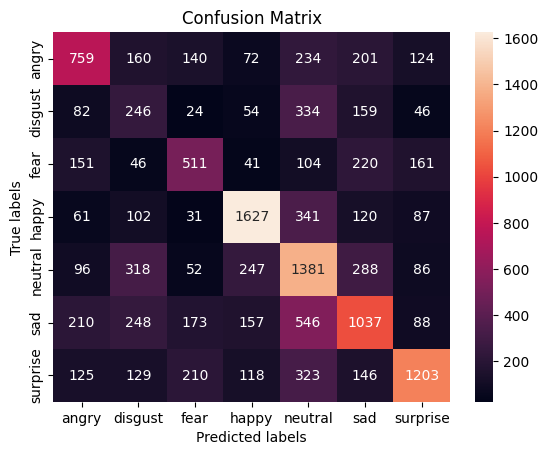

In [23]:
cm = confusion_matrix(true_class, predicted_class)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax)

# labels, title and ticks

ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")

ax.xaxis.set_ticklabels(
    ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
)

ax.yaxis.set_ticklabels(
    ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
)